In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
train = pd.read_csv('trains.csv')
test = pd.read_csv('test.csv')

for col in train.columns:
    col_type = train[col].dtypes
    min1 = train[col].min()
    max1 = train[col].max()
    if str(col_type)[:3] == 'int':
        train[col] = train[col].astype(np.int16)
    else:
        if min1 > np.finfo(np.float16).min and max1 < np.finfo(np.float16).max:
            train[col] = train[col].astype(np.float16)
        elif min1 > np.finfo(np.float32).min and max1 < np.finfo(np.float32).max:
            train[col] = train[col].astype(np.float32)
        else:
            train[col] = train[col].astype(np.float64)
train_X = train.iloc[:,4:]
train_Y = train.iloc[:,0:4]
test_X = test.iloc[:,1:]

In [24]:
from sklearn.preprocessing import MinMaxScaler
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()
scaler_y = yscaler.fit_transform(train_Y)
scaler_x = xscaler.fit_transform(train_X)

In [63]:
import keras
from keras import regularizers
from keras.constraints import max_norm
from keras.layers.recurrent import GRU
from keras.models import Sequential, Model
from keras.layers import *
from keras_radam import RAdam
from keras import optimizers
from keras import activations
def build_model():
    model = Sequential()
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(BatchNormalization())
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(BatchNormalization())
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(BatchNormalization())
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(BatchNormalization())
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(Dense(units=226, activation=swish, input_dim=226))
    model.add(Dense(units=4, activation='linear'))
    op = optimizers.Nadam(learning_rate = 0.005, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(loss='mae', optimizer=op, metrics=['mae'])
    return model
def swish(x) :
    return x * keras.activations.sigmoid(x)

def mish(x) :
    return x * keras.activations.tanh( keras.activations.softplus(x)) 

In [64]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import keras.backend as K
class LRFinder(Callback):
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

In [65]:
epochs = 100
batch_size = 1000
epoch_size = len(train_X)

lr_finder = LRFinder(min_lr=(1e-3), 
                     max_lr=1e-2, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)

early_stop = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

ckpt_dir = './ckpt'
ckpt_path = ckpt_dir + '/ResNetFinetuning_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

In [62]:
model11 = build_model()
model11.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 226)               51302     
_________________________________________________________________
batch_normalization_53 (Batc (None, 226)               904       
_________________________________________________________________
dense_134 (Dense)            (None, 226)               51302     
_________________________________________________________________
dense_135 (Dense)            (None, 226)               51302     
_________________________________________________________________
batch_normalization_54 (Batc (None, 226)               904       
_________________________________________________________________
dense_136 (Dense)            (None, 226)               51302     
_________________________________________________________________
dense_137 (Dense)            (None, 226)             

In [66]:
model11 = build_model()
model11.fit(train_X, train_Y, epochs=100,callbacks=[ckpt, lr_finder], batch_size=1000, validation_split = 0.02,shuffle=True,)

Train on 793800 samples, validate on 16200 samples
Epoch 1/100
793800/793800 [==============================] - 16s 20us/step - loss: 51.1573 - mae: 51.1573 - val_loss: 36.9046 - val_mae: 36.9046
Epoch 2/100
793800/793800 [==============================] - 15s 19us/step - loss: 17.0475 - mae: 17.0475 - val_loss: 23.5372 - val_mae: 23.5372
Epoch 3/100
793800/793800 [==============================] - 15s 19us/step - loss: 10.0130 - mae: 10.0130 - val_loss: 18.1417 - val_mae: 18.1417
Epoch 4/100
793800/793800 [==============================] - 15s 19us/step - loss: 7.7691 - mae: 7.7691 - val_loss: 17.0034 - val_mae: 17.0034
Epoch 5/100
793800/793800 [==============================] - 15s 19us/step - loss: 6.6670 - mae: 6.6670 - val_loss: 13.5097 - val_mae: 13.5097
Epoch 6/100
793800/793800 [==============================] - 15s 19us/step - loss: 6.0324 - mae: 6.0324 - val_loss: 14.2377 - val_mae: 14.2377
Epoch 7/100
793800/793800 [==============================] - 15s 19us/step - loss: 5.

793800/793800 [==============================] - 16s 20us/step - loss: 2.7657 - mae: 2.7657 - val_loss: 6.0234 - val_mae: 6.0234
Epoch 58/100
793800/793800 [==============================] - 15s 19us/step - loss: 2.7652 - mae: 2.7652 - val_loss: 6.1558 - val_mae: 6.1558
Epoch 59/100
793800/793800 [==============================] - 15s 19us/step - loss: 2.7511 - mae: 2.7511 - val_loss: 9.6065 - val_mae: 9.6065
Epoch 60/100
793800/793800 [==============================] - 15s 20us/step - loss: 2.7396 - mae: 2.7396 - val_loss: 7.1350 - val_mae: 7.1350
Epoch 61/100
793800/793800 [==============================] - 16s 20us/step - loss: 2.6963 - mae: 2.6963 - val_loss: 5.1071 - val_mae: 5.1071
Epoch 62/100
793800/793800 [==============================] - 16s 20us/step - loss: 2.6617 - mae: 2.6617 - val_loss: 5.6800 - val_mae: 5.6800
Epoch 63/100
793800/793800 [==============================] - 15s 20us/step - loss: 2.6765 - mae: 2.6765 - val_loss: 6.9703 - val_mae: 6.9703
Epoch 64/100
793800

In [ ]:
model11 = build_model()
model11.fit(train_X, train_Y, epochs=100,callbacks=[ckpt, lr_finder], batch_size=1000, validation_split = 0.02,shuffle=True,)

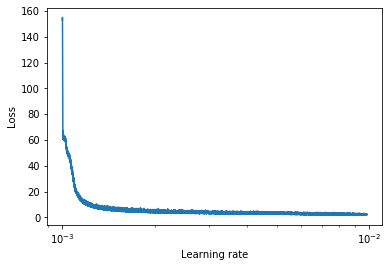

In [68]:
lr_finder.plot_loss()

In [76]:
model11.load_weights(ckpt_dir +'/ResNetFinetuning_46_valloss5.04.hdf5')
pred_test = model11.predict(test_X)
y_pred1 = pred_test
model11.load_weights(ckpt_dir +'/ResNetFinetuning_77_valloss4.93.hdf5')
pred_test = model11.predict(test_X)
y_pred2 = pred_test
# model11.load_weights(ckpt_dir +'/ResNetFinetuning_75_valloss0.09.hdf5')
# pred_test = model11.predict(xscaler.transform(test_X))
# y_pred3 = yscaler.inverse_transform(pred_test)
model11.load_weights(ckpt_dir +'/ResNetFinetuning_73_valloss5.01.hdf5')
pred_test = model11.predict(test_X)
y_pred4 = pred_test

In [73]:
y_pred = (y_pred1+y_pred2+y_pred4)/3

In [75]:
sample = pd.read_csv("sample_submission.csv")
sample.iloc[:,1:] = y_pred
sample.head()

,id,layer_1,layer_2,layer_3,layer_4
0,0,256.817383,229.649979,132.002975,86.540886
1,1,160.622375,125.623924,237.978683,99.343102
2,2,147.094894,175.322449,274.911041,156.503922
3,3,94.028076,232.451828,186.315689,83.999313
4,4,275.882904,294.187347,242.459412,271.388794


In [50]:
sample.to_csv("sample_sub1.csv",index=False)